In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


In [2]:
!tree


.
├── data
│   ├── Debt-enforcement-database-NBER.xls
│   ├── debt.csv
│   ├── debt_info.csv
│   ├── gdp_per_cap.csv
│   └── rule_of_law.csv
└── rule_of_law.ipynb

2 directories, 6 files


# Law

In [3]:
rule_of_law_df = pd.read_csv("data/rule_of_law.csv", delimiter=";")
debt_df = pd.read_csv("data/debt_info.csv", delimiter=";")
gdp_df = pd.read_csv("data/gdp_per_cap.csv")
corrupt_df = debt_df[["code","corrupt"]]
gdp_df = gdp_df[(gdp_df['Time'] == 2021)&(gdp_df['Subject'] == "GDP per head of population")&(gdp_df['Measure'] == "USD, current prices, current PPPs")]
gdp_df = gdp_df.rename(columns = {'LOCATION':'code'})
corrupt_df.head()

,code,corrupt
0,ALB,"6,528"
1,DZA,"5,714"
2,AGO,"5,000"
3,ARG,"6,012"
4,ARM,NaN


In [4]:
rule_of_law_df.columns = ["country","code","region","income group","rule of law"]
debt_df.head()

,code,country,igp,bkorigin,civil,eng,fren,ger,nordic,aproc,...,effbank,loan,credimp,sound,sophisti,formali,b_delayt,infraest,corrupt,taxevas
0,ALB,Albania,3. Lower Middle Income,German,1.0,0.0,0.0,1.0,0.0,liq,...,NaN,NaN,NaN,NaN,NaN,"76,389",NaN,NaN,"6,528",NaN
1,DZA,Algeria,3. Lower Middle Income,French,1.0,0.0,1.0,0.0,0.0,reorg,...,"4,1","2,2","3,6","4,1","1,7","72,222",NaN,NaN,"5,714",NaN
2,AGO,Angola,3. Lower Middle Income,French,1.0,0.0,1.0,0.0,0.0,reorg,...,"2,2","2,1","3,5","4,0","2,0","81,944",NaN,NaN,"5,000",NaN
3,ARG,Argentina,2. Upper middle income,French,1.0,0.0,1.0,0.0,0.0,reorg,...,"3,4","1,7","1,3","2,8","3,6","79,861","3,901","4,633","6,012","2,41"
4,ARM,Armenia,3. Lower Middle Income,German,1.0,0.0,0.0,1.0,0.0,fcl,...,NaN,NaN,NaN,NaN,NaN,"45,833",NaN,NaN,NaN,NaN


In [5]:

def clarify(df):
    answer = ""
    if df['civil'] == 1:
        answer += "civil "
    
    if df['eng'] == 1:
        answer += "common low"
    elif df['fren'] == 1:
        answer += "fren"
    elif df['ger'] == 1:
        answer += "ger"
    elif df['nordic'] == 1:
        answer += "nordic"
    return answer
    
debt_df["juridiq"] = debt_df.apply(clarify, axis=1)
debt_df.head()

,code,country,igp,bkorigin,civil,eng,fren,ger,nordic,aproc,...,loan,credimp,sound,sophisti,formali,b_delayt,infraest,corrupt,taxevas,juridiq
0,ALB,Albania,3. Lower Middle Income,German,1.0,0.0,0.0,1.0,0.0,liq,...,NaN,NaN,NaN,NaN,"76,389",NaN,NaN,"6,528",NaN,civil ger
1,DZA,Algeria,3. Lower Middle Income,French,1.0,0.0,1.0,0.0,0.0,reorg,...,"2,2","3,6","4,1","1,7","72,222",NaN,NaN,"5,714",NaN,civil fren
2,AGO,Angola,3. Lower Middle Income,French,1.0,0.0,1.0,0.0,0.0,reorg,...,"2,1","3,5","4,0","2,0","81,944",NaN,NaN,"5,000",NaN,civil fren
3,ARG,Argentina,2. Upper middle income,French,1.0,0.0,1.0,0.0,0.0,reorg,...,"1,7","1,3","2,8","3,6","79,861","3,901","4,633","6,012","2,41",civil fren
4,ARM,Armenia,3. Lower Middle Income,German,1.0,0.0,0.0,1.0,0.0,fcl,...,NaN,NaN,NaN,NaN,"45,833",NaN,NaN,NaN,NaN,civil ger


In [6]:
rule_law_df = rule_of_law_df.merge(debt_df[["code", "country", "juridiq"]], on="code").merge(gdp_df, on="code")[["Country","juridiq", "rule of law", "Value"]]
rule_law_df["Country"]

0           Australia
1             Austria
2             Belgium
3              Brazil
4              Canada
5               Chile
6            Colombia
7          Costa Rica
8      Czech Republic
9             Denmark
10            Estonia
11            Finland
12             France
13            Germany
14             Greece
15            Hungary
16          Indonesia
17            Ireland
18              Italy
19              Japan
20              Korea
21             Latvia
22          Lithuania
23             Mexico
24        Netherlands
25        New Zealand
26             Norway
27             Poland
28           Portugal
29    Slovak Republic
30           Slovenia
31              Spain
32             Sweden
33            Türkiye
34     United Kingdom
35      United States
Name: Country, dtype: object

In [7]:
rule_law_df = rule_law_df[["juridiq", "rule of law", "Value"]]
rule_law_df.columns = ["juridiq","rule_of_law", "gdp_per_capita"]
rule_law_df.groupby("juridiq").mean().applymap(lambda x: round(x, 3))

,rule_of_law,gdp_per_capita
juridiq,,
civil fren,0.624,34048.483
civil ger,0.716,43449.323
civil nordic,0.885,64695.985
common low,0.779,59770.683


# Some regression

In [8]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

## On choisit les colonnes numériques pour les standardiser

In [9]:
rule_law_updated_df = rule_of_law_df.merge(debt_df[["code", "country", "juridiq"]], on="code")\
        .merge(gdp_df, on="code")\
        .merge(corrupt_df, on="code")[["Country","juridiq", "rule of law", "Value", "corrupt"]]


In [10]:
rule_law_updated_df = rule_law_updated_df[["juridiq", "rule of law", "Value", "corrupt"]]
rule_law_updated_df.columns = ["juridiq","rule_of_law", "gdp_per_capita", "control_of_corruption"]
rule_law_updated_df.groupby("juridiq").mean().applymap(lambda x: round(x, 3))

,rule_of_law,gdp_per_capita
juridiq,,
civil fren,0.624,34048.483
civil ger,0.716,43449.323
civil nordic,0.885,64695.985
common low,0.779,59770.683


In [11]:
rule_law_updated_df.dtypes

juridiq                   object
rule_of_law              float64
gdp_per_capita           float64
control_of_corruption     object
dtype: object

In [12]:
rule_law_updated_df.dropna(inplace=True)
rule_law_updated_df["control_of_corruption"] = rule_law_updated_df["control_of_corruption"].map(lambda x: str(x))
rule_law_updated_df["control_of_corruption"] = rule_law_updated_df["control_of_corruption"].map(lambda x: x.replace(",", "."))
rule_law_updated_df["control_of_corruption"] = pd.to_numeric(rule_law_updated_df["control_of_corruption"])

In [13]:
features = ["rule_of_law", "gdp_per_capita", "control_of_corruption"]

df_standardized = standardize(rule_law_updated_df, features)

In [14]:
df_standardized.dtypes

juridiq                   object
rule_of_law              float64
gdp_per_capita           float64
control_of_corruption    float64
dtype: object

In [15]:
import statsmodels.formula.api as smf
model = smf.ols(formula = 'rule_of_law ~ gdp_per_capita + control_of_corruption + C(juridiq) -1', data=df_standardized).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rule_of_law   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     16.69
Date:                Fri, 31 Mar 2023   Prob (F-statistic):           2.90e-07
Time:                        10:13:52   Log-Likelihood:                -20.737
No. Observations:                  31   AIC:                             53.47
Df Residuals:                      25   BIC:                             62.08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(juridiq)[civil fren]      -0.1408      0.164     -0.857      0.400      -0.479       0.198
C(juridiq)[civil ger]       -0.1171      0.235     -0.497      0.623      -0.602       0.368
C(juridiq)[civil nordic]     0.4275      0.300      1.426      0.166      -0.190       1.045
C(juridiq)[common low]       0.1059      0.203      0.522      0.606      -0.312       0.523
gdp_per_capita               0.2969      0.144      2.066      0.049       0.001       0.593
control_of_corruption        0.5080      0.140      3.638      0.001       0.220       0.796
==============================================================================
Omnibus:                        2.142   Durbin-Watson:                   2.441
Prob(Omnibus):                  0.343   Jarque-Bera (JB):                1.740
Skew:                          -0.570   Prob(JB):                        0.419
Kurtosis:                       2.781   Cond. No.                         4.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
model.params

C(juridiq)[civil fren]     -0.140847
C(juridiq)[civil ger]      -0.117052
C(juridiq)[civil nordic]    0.427523
C(juridiq)[common low]      0.105878
gdp_per_capita              0.296890
control_of_corruption       0.507972
dtype: float64

In [17]:
def return_significative_coef(model):
    """
    Returns p_value, lower and upper bound coefficients
    from a statsmodels object.
    """
    # Extract p_values
    p_values = model.pvalues.reset_index()
    p_values.columns = ['variable', 'p_value']

    # Extract coef_int
    coef = model.params.reset_index()
    coef.columns = ['variable', 'coef']
    return p_values.merge(coef,
                          on='variable')\
                   .query("p_value<0.05").sort_values(by='coef',
                                                      ascending=False)


<AxesSubplot:>

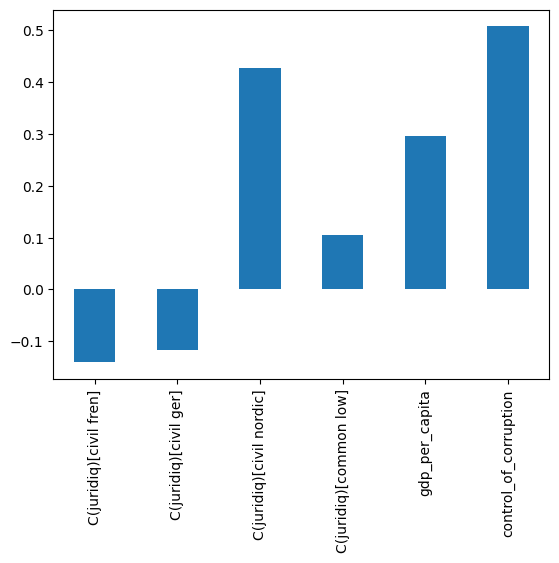

In [18]:
model.params.plot(kind="bar")

In [19]:
return_significative_coef(model)

,variable,p_value,coef
5,control_of_corruption,0.001248,0.507972
4,gdp_per_capita,0.049325,0.296890


eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


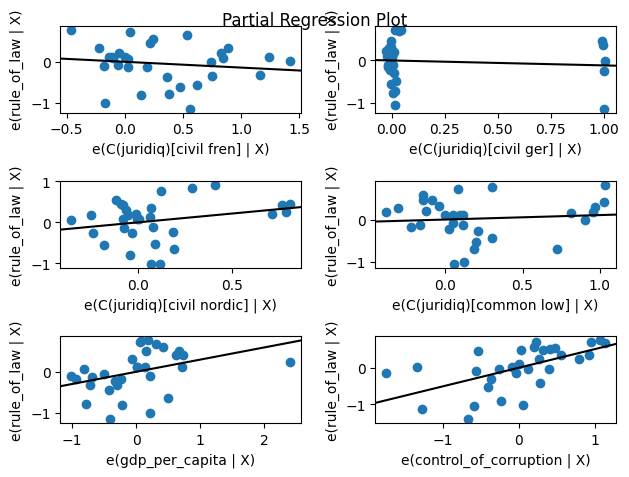

In [20]:
import statsmodels.api as sm

sm.graphics.plot_partregress_grid(model)
plt.show();